# Model Results Over Time

Triage includes a component called `audition` that can help you visualize your model results over time (as well as narrow down your best-performing models). This notebook will help you run `audition` for your project: be sure to fill in the appropriate parameters below!

In [3]:
from triage.component.audition import Auditioner
from triage.component.audition.pre_audition import PreAudition
from triage.component.audition.rules_maker import SimpleRuleMaker, RandomGroupRuleMaker, create_selection_grid

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import yaml
import sqlalchemy

import logging
logging.basicConfig(level=logging.WARNING)

import pandas as pd
pd.set_option('precision', 4)

# Parameters to Set

To run `audition`, you'll need to specify a few parameters below:

`db_config_path` is the path to the database.yaml file you're using to connect to the database when running triage

`metric` and `parameter` together specify the evaluation metric of interest for your project. Note that these need to be calculated as part of the `scoring` section in your triage config and should match the values in the columns of the same name in `test_results.evaluations`

The `run_hash` is an identifier for the run with your complete model grid that you want to evaluate -- the easiest way to find this is from the `triage_metadata.triage_runs` table. This will likely be the `run_hash` associated with the most recent record in that table, but you should be able to figure out which run you want to use from there.

**NOTE:** You shouldn't need to change anything below these parameters, but some comments are provided to give a little more detail on what the notebook is doing.

In [ ]:
db_config_path = '/path/to/your/database.yaml'
metric = 'precision@'
parameter = '1000_abs'
run_hash = 'a1316f404aecc9df9e3c5264b32770f8'

### Setting up the database connection

In [7]:
with open(db_config_path) as fd:
    config = yaml.load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgres",
        host=config["host"],
        username=config["user"],
        database=config["db"],
        password=config["pass"],
        port=config["port"],
    )
    conn = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

In [5]:
best_dist_table = 'aud_best_dist' 

## Pre-Audition

`PreAudition` provides some higher level functions to obtain `model_group_ids` and `train_end_times`. For example, `get_model_groups_from_experiment()` and `get_train_end_times()` (note that this will return the `train_end_times` associated with the set of model groups returned by one of the `get_model_groups` methods, so those should be run first)

Note that the `baseline_model_types` parameter in the constructor is optional and can be used to identify model groups as baselines rather than candidates for model selection

In [6]:
pre_aud = PreAudition(
    conn, 
    baseline_model_types=[
        'sklearn.dummy.DummyClassifier',
        'triage.component.catwalk.baselines.rankers.PercentileRankOneFeature',
        'triage.component.catwalk.baselines.thresholders.SimpleThresholder'
    ]
)

# select model groups by experiment hash id
model_groups = pre_aud.get_model_groups_from_experiment(run_hash)

# Note that this will find train_end_times associated with the model groups defined above
end_times = pre_aud.get_train_end_times(after='1900-01-01')

`get_model_groups_from_experiment()` returns a dictionary with keys `model_groups` and `baseline_model_groups`. 

How many of each did we get?

In [7]:
# Number of non-baseline model groups:
print(len(model_groups['model_groups']))

72


In [8]:
# Number of baseline model groups:
# if you don't see them there, your run_hash is not correct or you have not run the baseline models.
# make sure to do so in order to compare the ML mdoels results
print(len(model_groups['baseline_model_groups']))

1


`get_train_end_times()` returns a list of `train_end_times`:

In [9]:
end_times

[Timestamp('2011-01-01 00:00:00'),
 Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00')]

## Auditioner

Auditioner is the main API to do the rules selection and model groups selection. It filters model groups using a two-step process.
 - Broad thresholds to filter out truly bad models
 - A selection rule grid to find the best model groups over time for each of a variety of methods
 
Note that model groups that don't have full train_end_time periods will be excluded from the analysis, so it's important to **ensure that all model groups have been completed across all train/test splits**

When we set up our auditioner object, we need to give it a database connection, the model groups to consider (and optionally baseline model groups), train_end_times, and tell it how we're going to filter the models. Note that the `initial_metric_filters` parameter specified below tells `Auditioner` what metric and parameter we'll be using and starts off without any initial filtering constraints (which is what you'll typically want):

In [10]:
aud = Auditioner(
    db_engine = conn,
    model_group_ids = model_groups['model_groups'],
    train_end_times = end_times,
    initial_metric_filters = [{'metric': metric, 'parameter': parameter, 'max_from_best': 1.0, 'threshold_value': 0.0}],
    distance_table = best_dist_table,
    baseline_model_group_ids = model_groups['baseline_model_groups'] # optional
)

# How to use Auditioner

## Plotting the best distance metric and groups over time

This is done with the `plot_model_groups` method and may take a minute to generate. 
What it does is to get rid of really bad model groups wrt the metric of interest. 
    A model group is discarded if:
        - It’s never close to the “best” model (define close to best) or
        - If it’s metric is below a certain number (define min threshold) at least once

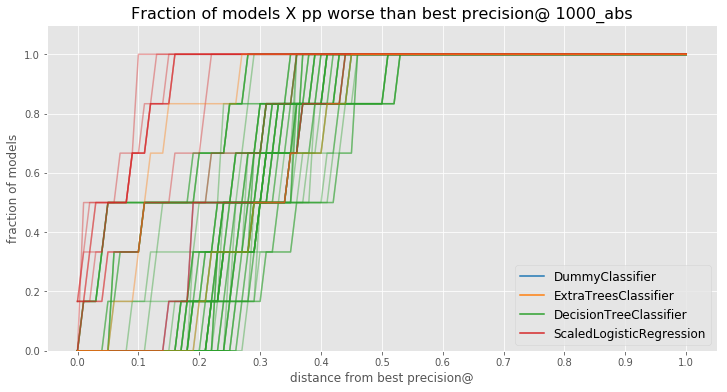

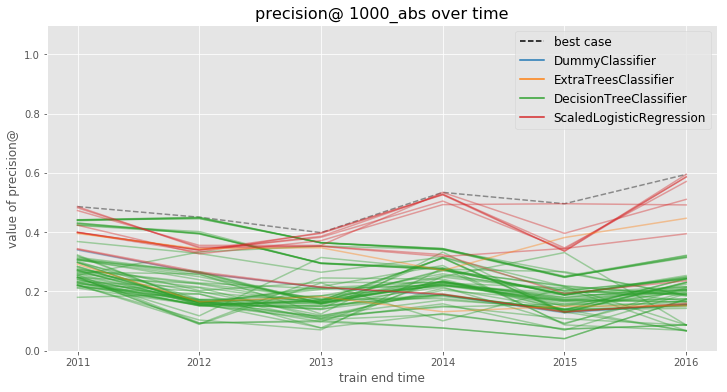

In [11]:
aud.plot_model_groups()

With our first default setting, we don't filter out models because `max_from_best`=`1.0` and `threshold_value`=`0.0` are the least restrictive criteria. It shows you all the model groups that are within `max_from_best` of the best model among all the times at least `threshold_value`% of the time.

- The first graph shows us the fraction of models worse than the best model by distance wrt the metric of interest.
- The second graph shows us the performance of a model group over time. The dashed line is the best case at that time period.

You can edit the parameters above or copy and paste them in the cells below and change the parameters to do further filtering.

In [12]:
# how many model groups do you have now after the filtering?

ids = aud.thresholded_model_group_ids
len(ids)

In [ ]:
# which model groups are left?
print(ids)

# you can explore the model groups and hyperparameters by looking at these models 
# in the database (triage_metadata.models table for example)

For now, we won't go further into the process model selection, but if you want to see more about how audition helps with that process, here are a couple of resources you could check out:

- [The full audition tutorial notebook](https://github.com/dssg/triage/blob/master/src/triage/component/audition/Audition_Tutorial.ipynb)
- [Audition Overview](https://dssg.github.io/triage/audition/audition_intro/)
- [Model Selection Overview](https://dssg.github.io/triage/audition/model_selection/)
